In [6]:
!pip install datasets pandas matplotlib seaborn nltk

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset

nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [2]:
!git clone https://github.com/Yale-LILY/QMSum.git

Cloning into 'QMSum'...
remote: Enumerating objects: 809, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 809 (delta 1), reused 0 (delta 0), pack-reused 804 (from 1)
Receiving objects: 100% (809/809), 13.76 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (446/446), done.


In [4]:
!ls /content/QMSum/data/ALL

jsonl  test  train  val


In [5]:
# !ls /content/QMSum/data/ALL/jsonl/train

!find /content/QMSum/data/ALL -name "*.jsonl"

/content/QMSum/data/ALL/jsonl/test.jsonl
/content/QMSum/data/ALL/jsonl/train.jsonl
/content/QMSum/data/ALL/jsonl/val.jsonl


In [7]:
# Load from local GitHub clone? or via huggingface loader?
# Option A: Local JSONL files from Yale-LILY/QMSum
def load_qmsum(path):
    items = []
    for line in open(path):
        obj = json.loads(line)
        for q in obj['general_query_list'] + obj['specific_query_list']:
            items.append({
                'meeting_id': obj.get('uid', obj.get('meeting_id', None)),
                'query': q['query'],
                'summary': q['answer'],
                'spans': q.get('relevant_text_span', [])
            })
    return pd.DataFrame(items)

# qmsum_df = load_qmsum('path/to/QMSum/data/ALL/train.jsonl')


In [8]:
qmsum_train_df = load_qmsum('/content/QMSum/data/ALL/jsonl/train.jsonl')
qmsum_val_df   = load_qmsum('/content/QMSum/data/ALL/jsonl/val.jsonl')
qmsum_test_df  = load_qmsum('/content/QMSum/data/ALL/jsonl/test.jsonl')

qmsum_train_df['split'] = 'train'
qmsum_val_df['split'] = 'val'
qmsum_test_df['split'] = 'test'

qmsum_df = pd.concat([qmsum_train_df, qmsum_val_df, qmsum_test_df], ignore_index=True)
qmsum_df.head()


,meeting_id,query,summary,spans,split
0,None,Summarize the whole meeting.,"Firstly, Project Manager reviewed the overall ...",[],train
1,None,How Did Project Manager and User Interface int...,Project Manager introduced that the prototype ...,"[[0, 39]]",train
2,None,How did Marketing design the product evaluation?,Marketing had some evaluation criteria in mind...,"[[54, 61]]",train
3,None,What did the team discuss during the product e...,"Generally speaking, the team agreed that the p...","[[64, 189]]",train
4,None,How did the team evaluate the product about it...,"To start with, the team agreed that the remote...","[[190, 249]]",train


In [9]:
print("Total rows:", len(qmsum_df))
print("Unique meetings:", qmsum_df['meeting_id'].nunique())
print("Query types:", qmsum_df.columns)  # make sure 'query', 'summary', 'spans' exist

Total rows: 1810
Unique meetings: 0
Query types: Index(['meeting_id', 'query', 'summary', 'spans', 'split'], dtype='object')


In [10]:
# from nltk.tokenize import word_tokenize # added to the top

qmsum_df["query_tokens"] = qmsum_df["query"].apply(lambda x: len(word_tokenize(x)))
qmsum_df["summary_tokens"] = qmsum_df["summary"].apply(lambda x: len(word_tokenize(x)))


In [30]:
qmsum_df

,meeting_id,query,summary,spans,split,query_tokens,summary_tokens
0,None,Summarize the whole meeting.,"Firstly, Project Manager reviewed the overall ...",[],train,5,152
1,None,How Did Project Manager and User Interface int...,Project Manager introduced that the prototype ...,"[[0, 39]]",train,15,104
2,None,How did Marketing design the product evaluation?,Marketing had some evaluation criteria in mind...,"[[54, 61]]",train,8,68
3,None,What did the team discuss during the product e...,"Generally speaking, the team agreed that the p...","[[64, 189]]",train,18,93
4,None,How did the team evaluate the product about it...,"To start with, the team agreed that the remote...","[[190, 249]]",train,13,77
...,...,...,...,...,...,...,...
1805,None,What did User Interface think about remote con...,User Interface agreed with Industrial Designer...,"[[152, 186]]",test,10,61
1806,None,What did Industrial Designer think about remot...,Industrial Designer believed that a modern rem...,"[[107, 118]]",test,10,31
1807,None,What did the group discuss about the connectio...,Industrial Designer pointed out that infrared ...,"[[119, 136], [278, 297]]",test,14,37
1808,None,What did Industrial Designer suggest when disc...,Industrial Designer proposed to change the way...,"[[119, 136]]",test,15,31


In [39]:
import ast  # safely evaluates string to Python object

# Convert spans string to actual list of lists
qmsum_df["spans"] = qmsum_df["spans"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Compute span lengths
def compute_span_length(span_list):
    try:
        return sum(int(end) - int(start) for start, end in span_list)
    except Exception:
        return 0

span_lengths = qmsum_df["spans"].apply(compute_span_length)

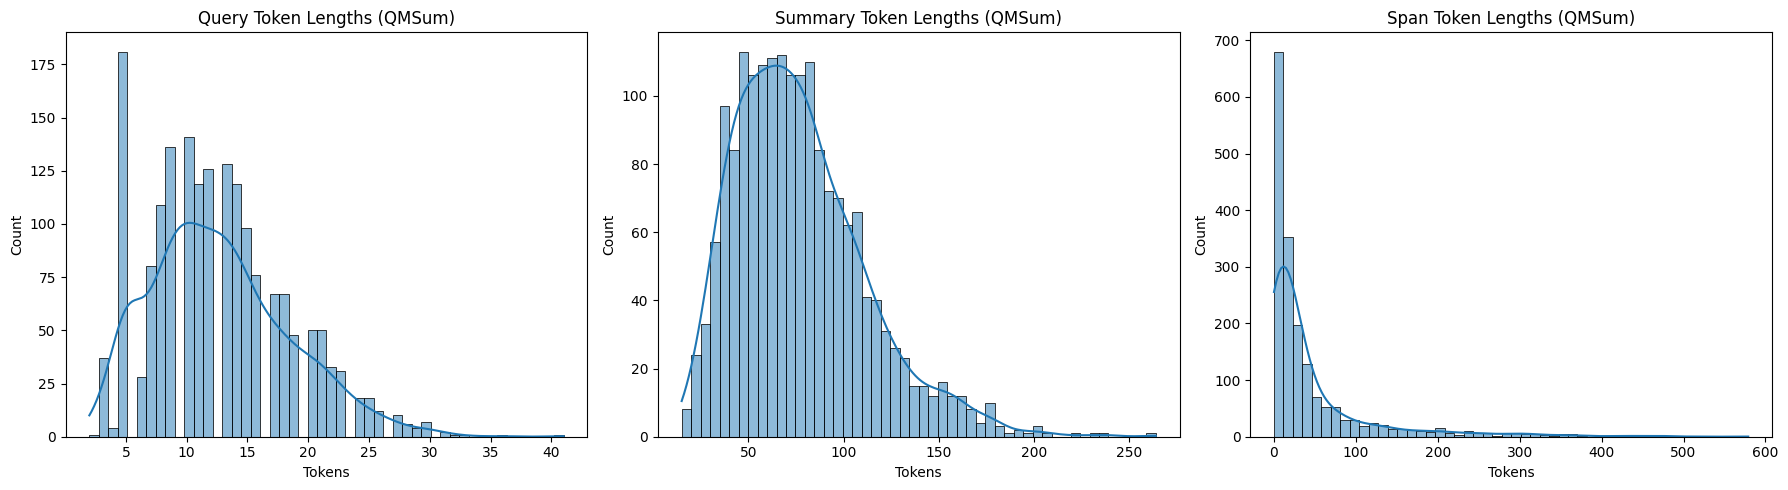

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(qmsum_df["query_tokens"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Query Token Lengths (QMSum)")
axes[0].set_xlabel("Tokens")

sns.histplot(qmsum_df["summary_tokens"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Summary Token Lengths (QMSum)")
axes[1].set_xlabel("Tokens")

sns.histplot(span_lengths, bins=50, kde=True, ax=axes[2])
axes[2].set_title("Span Token Lengths (QMSum)")
axes[2].set_xlabel("Tokens")

plt.tight_layout()
plt.show()


### Loading SQuALITY

In [13]:
!git clone https://github.com/nyu-mll/SQuALITY.git

Cloning into 'SQuALITY'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 136 (delta 58), reused 102 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (136/136), 4.18 MiB | 13.09 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [18]:
!find /content/SQuALITY -name "*.jsonl"

/content/SQuALITY/data/v1/test.jsonl
/content/SQuALITY/data/v1/train.jsonl
/content/SQuALITY/data/v1/dev.jsonl
/content/SQuALITY/data/human-eval/all-responses.jsonl
/content/SQuALITY/data/v1-1/test.jsonl
/content/SQuALITY/data/v1-1/train.jsonl
/content/SQuALITY/data/v1-1/dev.jsonl
/content/SQuALITY/data/v1-2/html/test.jsonl
/content/SQuALITY/data/v1-2/html/train.jsonl
/content/SQuALITY/data/v1-2/html/dev.jsonl
/content/SQuALITY/data/v1-2/txt/test.jsonl
/content/SQuALITY/data/v1-2/txt/train.jsonl
/content/SQuALITY/data/v1-2/txt/dev.jsonl
/content/SQuALITY/data/v1-3/html/test.jsonl
/content/SQuALITY/data/v1-3/html/train.jsonl
/content/SQuALITY/data/v1-3/html/dev.jsonl
/content/SQuALITY/data/v1-3/txt/test.jsonl
/content/SQuALITY/data/v1-3/txt/train.jsonl
/content/SQuALITY/data/v1-3/txt/dev.jsonl


In [20]:
with open('/content/SQuALITY/data/v1-1/train.jsonl') as f:
    example = json.loads(f.readline())
print(json.dumps(example, indent=2))

{
  "metadata": {
    "passage_id": "61263",
    "uid": "3ca15c335843477eaa38ed31980680be",
    "license": ""
  },
  "document": "<!DOCTYPE html PUBLIC \"-//W3C//DTD XHTML 1.0 Strict//EN\"\n    \"http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd\">\nCULTURAL EXCHANGE\nBY KEITH LAUMER\nIt was a simple student exchange\u2014but\nRetief gave them more of\nan education than they expected!\n[Transcriber's Note: This etext was produced from\nWorlds of If Science Fiction, September 1962.\nExtensive research did not uncover any evidence that\nthe U.S. copyright on this publication was renewed.]\nI\nSecond Secretary Magnan took his green-lined cape and orange-feathered\nberet from the clothes tree. \"I'm off now, Retief,\" he said. \"I hope\nyou'll manage the administrative routine during my absence without any\nunfortunate incidents.\"\n\"That seems a modest enough hope,\" Retief said. \"I'll try to live up to\nit.\"\n\"I don't appreciate frivolity with reference to this Division,\" Magnan\nsa

In [23]:
with open('/content/SQuALITY/data/v1-1/train.jsonl') as f:
    ex = json.loads(f.readline())
    print(json.dumps(ex['questions'][0]['responses'][0], indent=2))

{
  "worker_id": "2",
  "uid": "18c9c61e7ecc4132b9ef185ffceda36f",
  "response_text": "Second Secretary Magnan will be away from the Manpower Utilization Directorate, Division of Libraries and Education (MUDDLE) for two weeks, leaving Retief in charge. Magnan reminds Retief that his role is to act as a rubber stamp, continuing Magnan\u2019s actions. Magnan points out that Retief should appreciate that Bogan is participating in the Exchange Program. Its participation might be a step toward sublimating their aggression into more cultivated channels. The Bogans are sending two thousand students to d\u2019Land as exchange students, and Magnan thinks this might end their aggression and bring them into the cultural life of the Galaxy. Retief wonders aloud what the students will study in such a poor, industrial land. Magnan points out that this is none of Retief\u2019s concern and that his role is simply to facilitate bringing the two groups together. When Miss Furkle, the secretary, buzzes M

In [24]:
def load_squality_jsonl(path, split):
    rows = []
    with open(path, "r") as f:
        for line in f:
            ex = json.loads(line)
            story = ex['document']
            uid = ex['metadata']['uid']
            for q in ex['questions']:
                question = q['question_text']
                for response in q['responses']:
                    rows.append({
                        'story_id': uid,
                        'story': story,
                        'question': question,
                        'response': response['response_text'],
                        'split': split
                    })
    return pd.DataFrame(rows)

In [25]:
squality_train_df = load_squality_jsonl('/content/SQuALITY/data/v1-1/train.jsonl', 'train')
squality_val_df   = load_squality_jsonl('/content/SQuALITY/data/v1-1/dev.jsonl', 'val')
squality_test_df  = load_squality_jsonl('/content/SQuALITY/data/v1-1/test.jsonl', 'test')

squality_df = pd.concat([squality_train_df, squality_val_df, squality_test_df], ignore_index=True)

In [26]:
squality_df

,story_id,story,question,response,split
0,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the plot of the story?,Second Secretary Magnan will be away from the ...,train
1,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the plot of the story?,Retief is left in charge of his division while...,train
2,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the plot of the story?,\tAfter Second Secretary Magnan took his tempo...,train
3,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the plot of the story?,Corps HQ is a diplomatic entity that houses a ...,train
4,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...","Who are the Bogans, and what happens to their ...",The Bogans are people who have a history of ag...,train
...,...,...,...,...,...
2535,bc0f3036c4bc459db4d3aa519655ffae,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",Describe the relationship between Captain Mida...,Captain Midas and Mister Spinelli initially ge...,test
2536,bc0f3036c4bc459db4d3aa519655ffae,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the significance of the mystery metal ...,The mystery metal is significant because it in...,test
2537,bc0f3036c4bc459db4d3aa519655ffae,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the significance of the mystery metal ...,All the spacemen in this story are greedy and ...,test
2538,bc0f3036c4bc459db4d3aa519655ffae,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the significance of the mystery metal ...,The mystery metal from the derelict can draw e...,test


In [27]:
squality_df["story_tokens"] = squality_df["story"].apply(lambda x: len(word_tokenize(x)))
squality_df["question_tokens"] = squality_df["question"].apply(lambda x: len(word_tokenize(x)))
squality_df["response_tokens"] = squality_df["response"].apply(lambda x: len(word_tokenize(x)))
squality_df.head()

,story_id,story,question,response,split,story_tokens,question_tokens,response_tokens
0,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the plot of the story?,Second Secretary Magnan will be away from the ...,train,6812,8,561
1,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the plot of the story?,Retief is left in charge of his division while...,train,6812,8,297
2,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the plot of the story?,\tAfter Second Secretary Magnan took his tempo...,train,6812,8,559
3,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",What is the plot of the story?,Corps HQ is a diplomatic entity that houses a ...,train,6812,8,520
4,3ca15c335843477eaa38ed31980680be,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...","Who are the Bogans, and what happens to their ...",The Bogans are people who have a history of ag...,train,6812,12,522


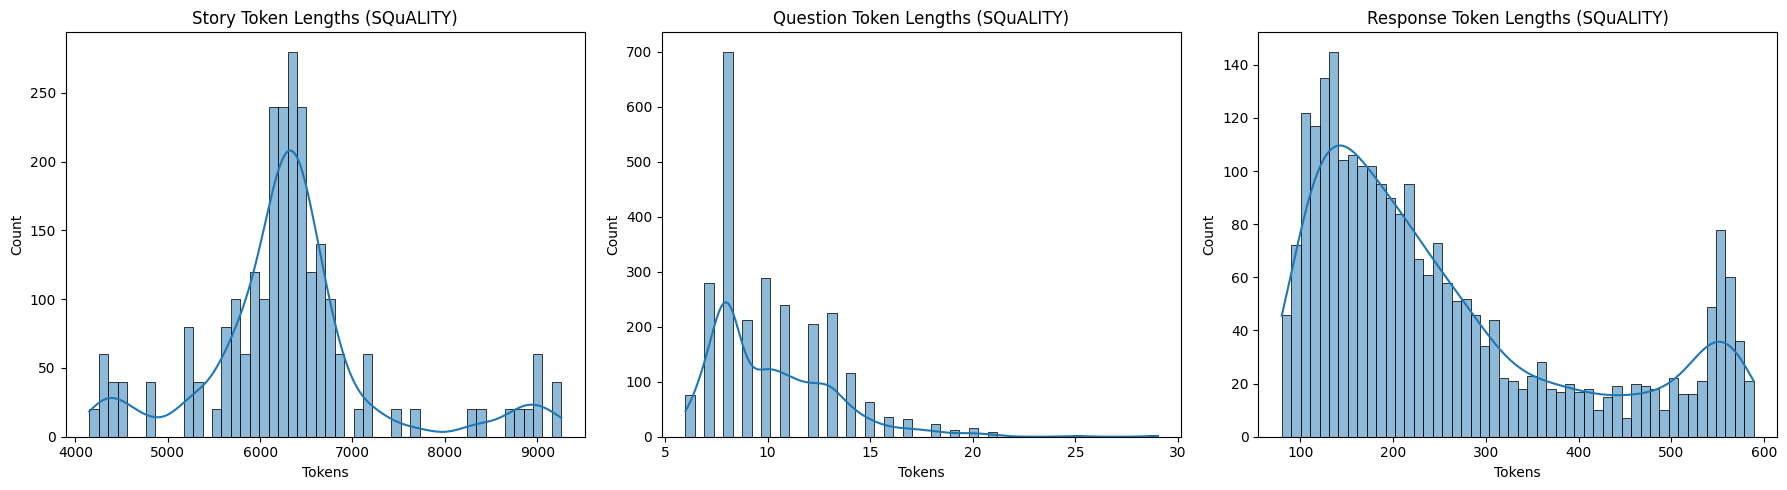

In [28]:
# Side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(squality_df["story_tokens"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Story Token Lengths (SQuALITY)")
axes[0].set_xlabel("Tokens")

sns.histplot(squality_df["question_tokens"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Question Token Lengths (SQuALITY)")
axes[1].set_xlabel("Tokens")

sns.histplot(squality_df["response_tokens"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Response Token Lengths (SQuALITY)")
axes[2].set_xlabel("Tokens")

plt.tight_layout()
plt.show()

## Comparison

In [42]:
# Compute summary stats for SQuALITY
squality_stats = {
    "Dataset": "SQuALITY",
    "Avg Question Tokens": squality_df["question_tokens"].mean(),
    "Avg Summary/Response Tokens": squality_df["response_tokens"].mean(),
    "Avg Source Tokens": squality_df["story_tokens"].mean()
}

# Compute summary stats for QMSum
qmsum_stats = {
    "Dataset": "QMSum",
    "Avg Question Tokens": qmsum_df["query_tokens"].mean(),
    "Avg Summary/Response Tokens": qmsum_df["summary_tokens"].mean(),
    "Avg Source Tokens": float('nan')  # no source text loaded
}

# Combine into a DataFrame
comparison_df = pd.DataFrame([squality_stats, qmsum_stats])
comparison_df

,Dataset,Avg Question Tokens,Avg Summary/Response Tokens,Avg Source Tokens
0,SQuALITY,10.185827,253.864567,6329.283465
1,QMSum,12.714365,76.912155,NaN
